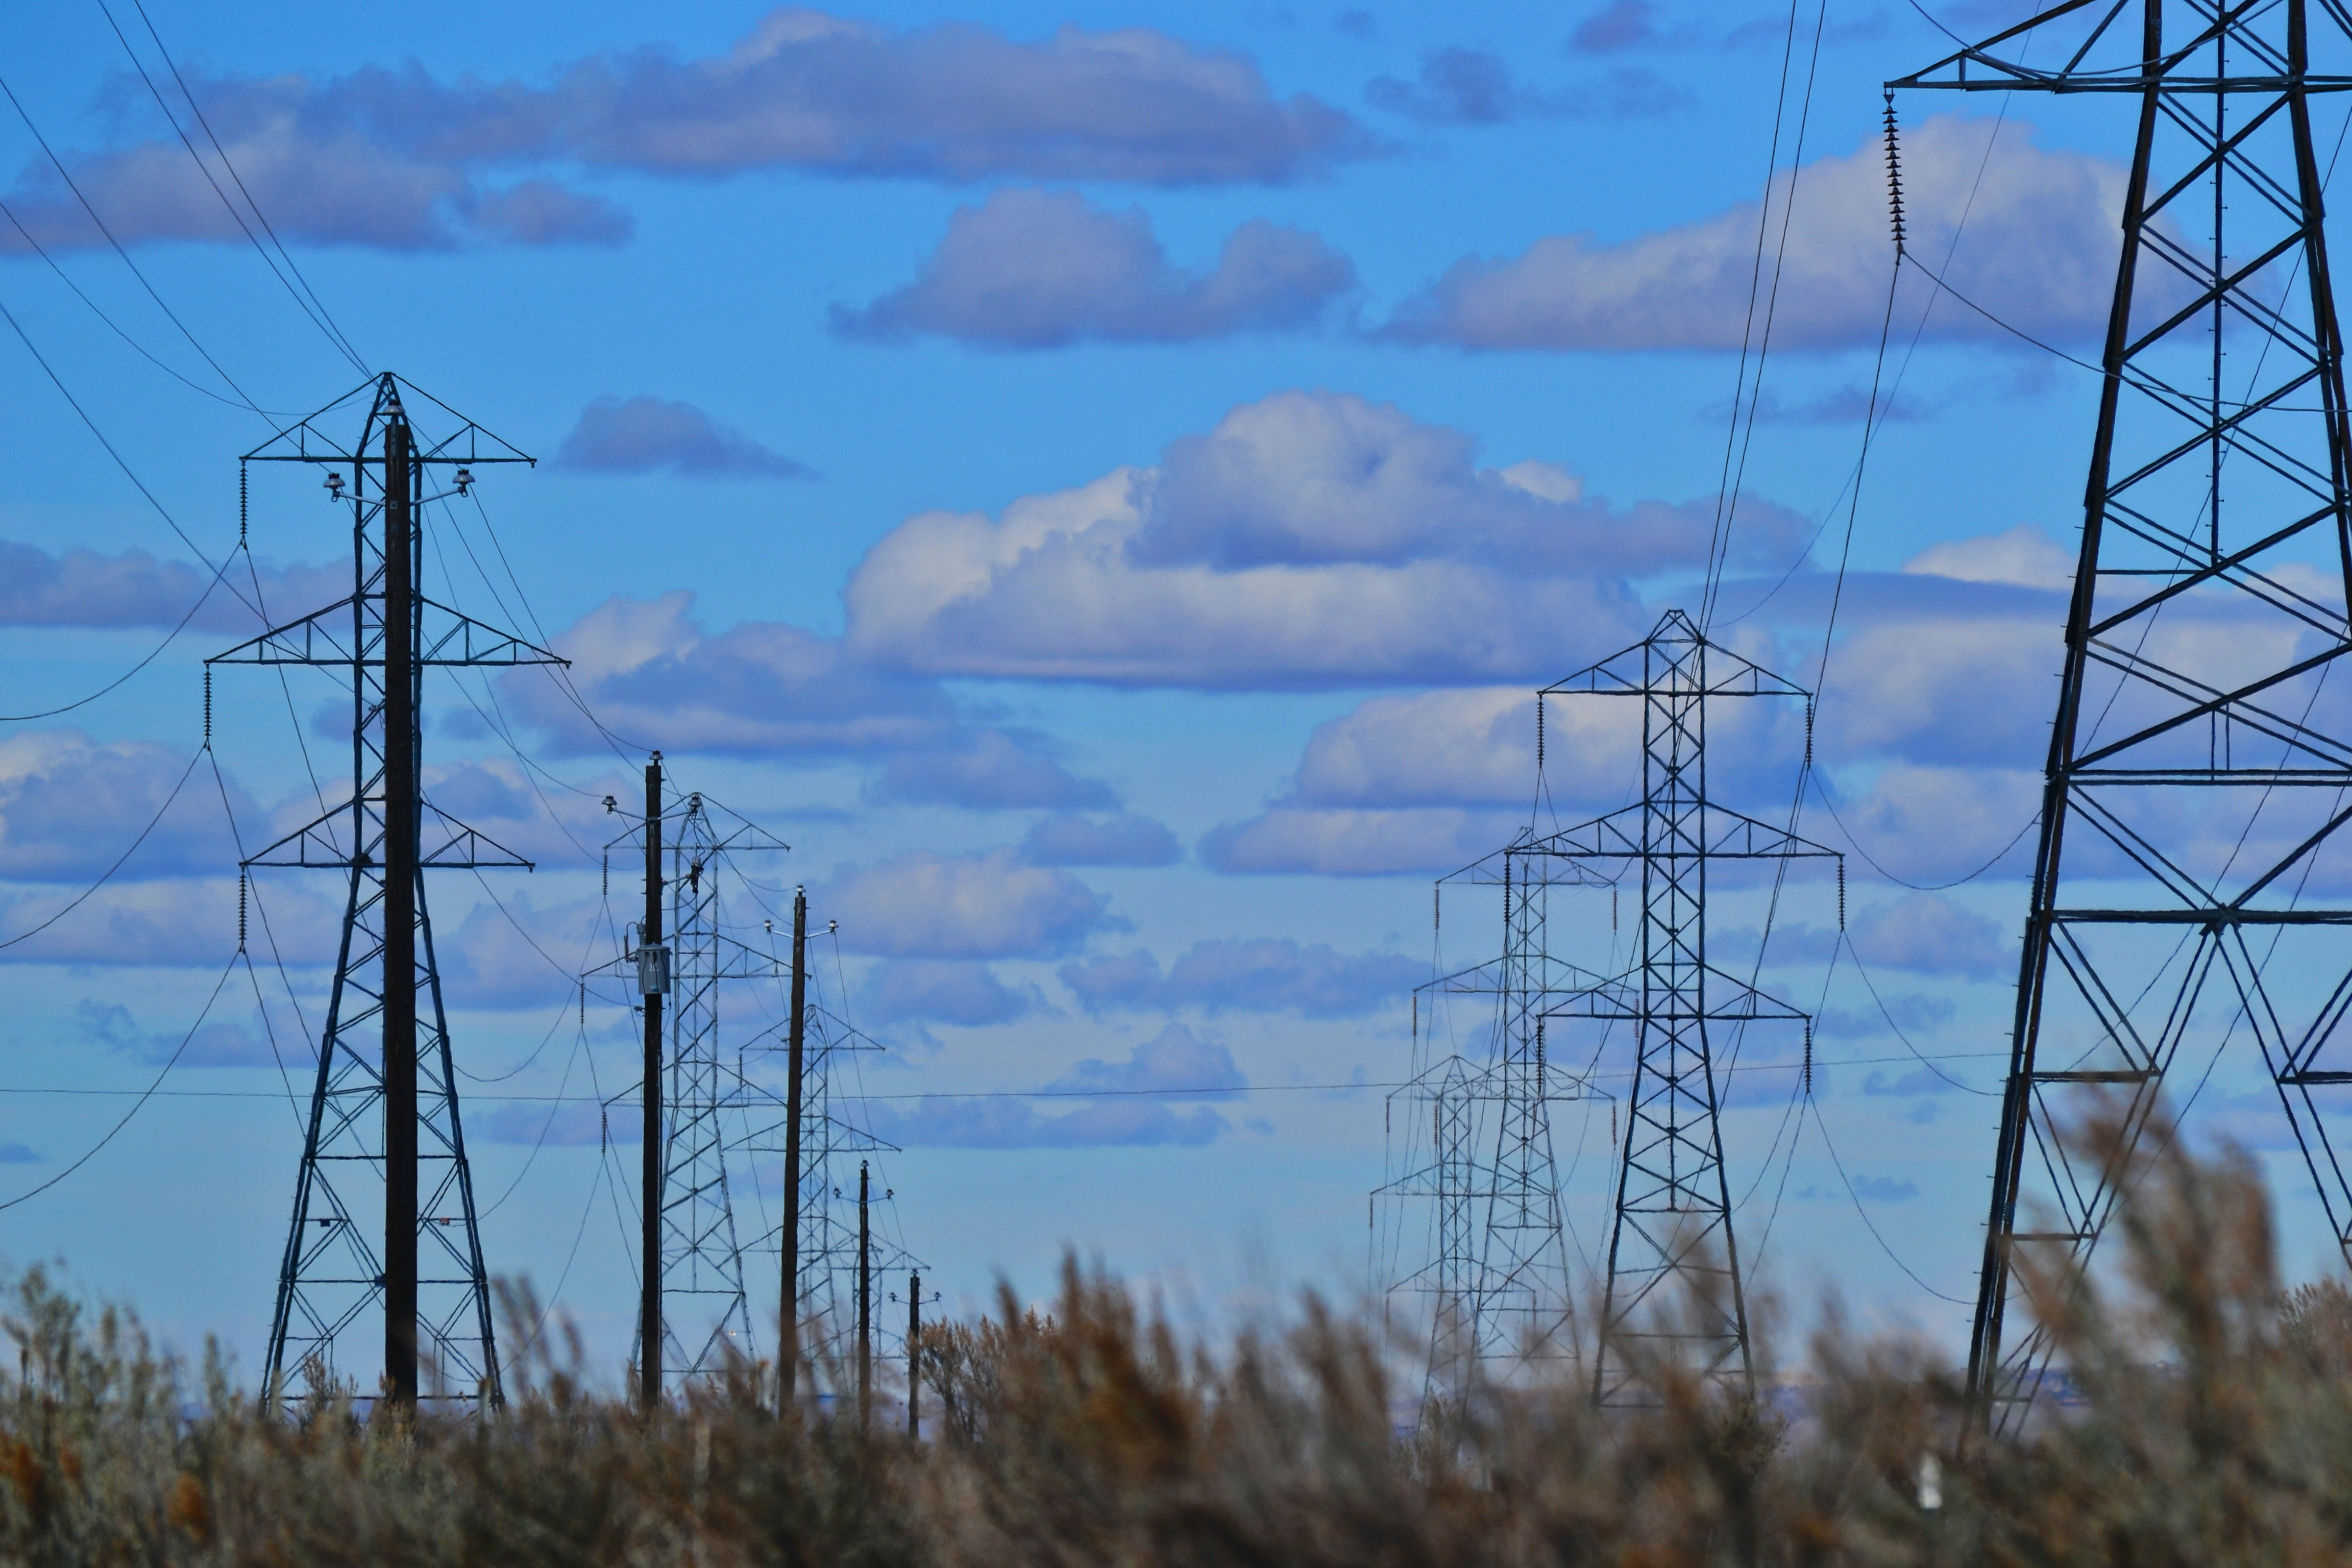

# Business Problem

The American Energy Market Regulator (AEMR) monitors the United States of America’s domestic energy network to ensure that our energy network remains reliable with minimal disruptions, also known as outages.

These are the four key types of outages:

● Consequential

● Forced

● Opportunistic

● Planned 

Recently, the AEMR management team has been increasingly aware of a large number of energy providers that submitted outages over the 2016 and 2017 calendar years. The management team wants the following two areas of concern addressed:

A) Energy Stability and Market Outages

B) Energy Losses and Market Reliability

In [1]:
%%capture
!pip install ipython-sql sqlalchemy
import sqlalchemy
sqlalchemy.create_engine("sqlite:///AEMR.db")
%load_ext sql
%sql sqlite:///AEMR.db

In [2]:
%%js
require(['notebook/js/codecell'], function (codecell) {
    codecell.CodeCell.options_default.highlight_modes['magic_text/x-mssql'] = { 'reg': [/%?%sql/] };
    Jupyter.notebook.events.one('kernel_ready.Kernel', function () {
        Jupyter.notebook.get_cells().map(function (cell) {
            if (cell.cell_type == 'code') { cell.auto_highlight(); }
        });
    });
});

<IPython.core.display.Javascript object>

# # First I will get a sense of the data the table provides

In [3]:
%%sql
SELECT *
FROM AEMR_Outage_Table
LIMIT 2;

 * sqlite:///AEMR.db
Done.


EventID,Start_Time,End_Time,Year,Month,Facility_Code,Participant_Code,Status,Outage_Reason,Energy_Lost_MW,Description_Of_Outage
1,2017-12-28 06:00,2017-12-28 10:00,2017,12,DNHR_DENMARK_WF1,DNHR,Approved,Consequential,1.44,a network outage in Denmark caused the windfarm to trip at 6:26 am
2,2017-12-26 09:00,2017-12-27 00:00,2017,12,COLLGAR_WF1,COLLGAR,Approved,Forced,30.0,Forced Outage - BS on Overhead line pole S-81 - CG10/11


# Energy Stability & Market Outages 

How many Outage Events are there per Outage_Reason?


In [4]:
%%sql
SELECT COUNT(Status) AS Total_Number_Outages, Outage_Reason, Year
FROM AEMR_Outage_Table
WHERE Status='Approved' AND Year IN (2016, 2017)
GROUP BY Outage_Reason, Year
ORDER BY year DESC;

 * sqlite:///AEMR.db
Done.


Total_Number_Outages,Outage_Reason,Year
127,Consequential,2017
1622,Forced,2017
102,Opportunistic Maintenance (Planned),2017
320,Scheduled (Planned),2017
181,Consequential,2016
1264,Forced,2016
106,Opportunistic Maintenance (Planned),2016
380,Scheduled (Planned),2016


Let's look at the total number of Outage Events by Year and Month.

In [5]:
%%sql
SELECT Year, Month, COUNT (Status) AS Total_Number_Outages
FROM AEMR_Outage_Table
WHERE Status='Approved' AND Year IN (2016, 2017)
GROUP BY Year, Month
ORDER BY Year, Month, Total_Number_Outages DESC;


 * sqlite:///AEMR.db
Done.


Year,Month,Total_Number_Outages
2016,1,191
2016,2,227
2016,3,136
2016,4,134
2016,5,174
2016,6,168
2016,7,147
2016,8,194
2016,9,124
2016,10,124


Now let's see how long he average outage lasts in days.

In [6]:
%%sql
SELECT Participant_Code, Outage_Reason, Year,COUNT (Status) AS Total_Number_Outage_Events, ROUND(AVG(ABS(JULIANDAY(Start_Time)-JULIANDAY(End_Time))),2) AS Average_Outage_Duration_In_Days
FROM AEMR_Outage_Table
WHERE Status = 'Approved' AND Year IN (2016, 2017)
GROUP BY Outage_Reason, Year
ORDER BY Total_Number_Outage_Events, Outage_Reason, Year DESC;

 * sqlite:///AEMR.db
Done.


Participant_Code,Outage_Reason,Year,Total_Number_Outage_Events,Average_Outage_Duration_In_Days
MELK,Opportunistic Maintenance (Planned),2017,102,0.31
KORL,Opportunistic Maintenance (Planned),2016,106,0.35
DNHR,Consequential,2017,127,0.56
DNHR,Consequential,2016,181,0.39
MELK,Scheduled (Planned),2017,320,3.5
ENRG,Scheduled (Planned),2016,380,3.43
COLLGAR,Forced,2016,1264,0.49
COLLGAR,Forced,2017,1622,0.64


Now, I'm going to classify the risk level of each participant based on average duration of an outage

'High Risk' = over 24 hours
'Medium Risk' = less than 24 hours and more than 12 hours
'Low Risk'=less than 12 hours

In [7]:
%%sql
WITH Avg_Outage_Table AS (
SELECT Participant_Code, Outage_Reason, Year,COUNT (Status) AS Total_Number_Outage_Events, 
    ROUND(AVG(ABS(JULIANDAY(Start_Time)-JULIANDAY(End_Time))),2) AS Average_Outage_Duration_In_Days
FROM AEMR_Outage_Table
WHERE Status = 'Approved' AND Year IN (2016, 2017)
GROUP BY Participant_Code, Outage_Reason, Year)

SELECT Participant_Code, Outage_Reason, Year, Total_Number_Outage_Events, Average_Outage_Duration_In_Days,
case when Average_Outage_Duration_In_Days > 1.00 then 'High Risk'
     when Average_Outage_Duration_In_Days < 1.00 and Average_Outage_Duration_In_Days > .50 then 'Medium Risk'
     else 'Low Risk'
end as Risk_Classification
FROM Avg_Outage_Table
GROUP BY Participant_Code, Outage_Reason, Year
ORDER BY Average_Outage_Duration_In_Days DESC;

 * sqlite:///AEMR.db
Done.


Participant_Code,Outage_Reason,Year,Total_Number_Outage_Events,Average_Outage_Duration_In_Days,Risk_Classification
WGUTD,Scheduled (Planned),2017,1,10.58,High Risk
KORL,Scheduled (Planned),2016,20,6.96,High Risk
MELK,Scheduled (Planned),2017,70,6.89,High Risk
COLLGAR,Scheduled (Planned),2017,9,6.36,High Risk
EUCT,Forced,2016,11,5.9,High Risk
ENRG,Scheduled (Planned),2017,37,4.96,High Risk
ENRG,Scheduled (Planned),2016,29,4.85,High Risk
MELK,Scheduled (Planned),2016,85,4.61,High Risk
GW,Scheduled (Planned),2016,45,4.43,High Risk
COLLGAR,Scheduled (Planned),2016,12,4.28,High Risk


Now let's consider number of Outage Events
 
High Risk - On average, the participant is unavailable for > 24 Hours (1 Day) OR the Total Number of Outage Events > 20
Medium Risk - On average, the participant is unavailable between 12 and 24 Hours OR the Total Number of Outage Events is Between 10 and 20
Low Risk - On average, the participant is unavailable for less than 12 Hours OR the Total Number of Outage Events < 10
If Outage Type is not forced, then N/A 

In [8]:
%%sql
WITH Avg_Outage_Table AS (
SELECT Participant_Code, Outage_Reason, Year,COUNT (Status) AS Total_Number_Outage_Events, 
    ROUND(AVG(ABS(JULIANDAY(Start_Time)-JULIANDAY(End_Time))),2) AS Average_Outage_Duration_In_Days
FROM AEMR_Outage_Table
WHERE Status = 'Approved' AND Year IN (2016, 2017)
GROUP BY Participant_Code, Outage_Reason, Year)

SELECT Participant_Code, Outage_Reason, Year, Total_Number_Outage_Events, Average_Outage_Duration_In_Days,
case when Average_Outage_Duration_In_Days > 1.00 OR Total_Number_Outage_Events > 20 then 'High Risk' 
     when Average_Outage_Duration_In_Days < 1.00 and Average_Outage_Duration_In_Days > .50 OR Total_Number_Outage_Events < 20 AND Total_Number_Outage_Events > 10 then 'Medium Risk'
     else 'Low Risk'
end as Risk_Classification
FROM Avg_Outage_Table
GROUP BY Participant_Code, Outage_Reason, Year
ORDER BY Average_Outage_Duration_In_Days DESC;

 * sqlite:///AEMR.db
Done.


Participant_Code,Outage_Reason,Year,Total_Number_Outage_Events,Average_Outage_Duration_In_Days,Risk_Classification
WGUTD,Scheduled (Planned),2017,1,10.58,High Risk
KORL,Scheduled (Planned),2016,20,6.96,High Risk
MELK,Scheduled (Planned),2017,70,6.89,High Risk
COLLGAR,Scheduled (Planned),2017,9,6.36,High Risk
EUCT,Forced,2016,11,5.9,High Risk
ENRG,Scheduled (Planned),2017,37,4.96,High Risk
ENRG,Scheduled (Planned),2016,29,4.85,High Risk
MELK,Scheduled (Planned),2016,85,4.61,High Risk
GW,Scheduled (Planned),2016,45,4.43,High Risk
COLLGAR,Scheduled (Planned),2016,12,4.28,High Risk


# Energy Losses & Market Reliability

Now let's look at the proportion of Forced outages taht have happened over the 2016-2017 period?

In [9]:
%%sql
SELECT Year, SUM(CASE WHEN Outage_Reason = 'Forced' THEN 1 ELSE 0 END) AS Total_Forced_Outages, COUNT(Outage_Reason) AS Total_Outages,
ROUND(CAST(SUM(CASE WHEN Outage_Reason = 'Forced' THEN 1 ELSE 0 END) AS float)/COUNT(Outage_Reason) * 100,2) AS Pct_Outage_Forced
FROM AEMR_Outage_Table
WHERE Status = 'Approved'
GROUP BY Year;


 * sqlite:///AEMR.db
Done.


Year,Total_Forced_Outages,Total_Outages,Pct_Outage_Forced
2016,1264,1931,65.46
2017,1622,2171,74.71


Now let's consider Total Energy Lost

In [10]:
%%sql
SELECT COUNT(Status) AS Total_Number_Outages, 
ROUND(ABS(JULIANDAY(Start_Time)-JULIANDAY(End_Time)),3) AS Total_Duration_In_Days,
ROUND(SUM(Energy_Lost_MW),2) AS Total_Energy_Lost, Outage_Reason, Participant_Code, Facility_Code, Year
FROM AEMR_Outage_Table
WHERE Status='Approved' AND Year IN (2016, 2017)
GROUP BY Participant_Code, Facility_Code
ORDER BY Energy_Lost_MW, Year DESC;

 * sqlite:///AEMR.db
Done.


Total_Number_Outages,Total_Duration_In_Days,Total_Energy_Lost,Outage_Reason,Participant_Code,Facility_Code,Year
25,0.167,36.0,Consequential,DNHR,DNHR_DENMARK_WF1,2017
536,0.0,46966.09,Forced,MELK,MELK_G7,2017
875,0.0,52243.66,Forced,AURICON,AURICON_PNJ_U1,2017
110,0.125,1981.8,Consequential,TSLA_MGT,TESLA_PICTON_G1,2017
247,0.0,6585.9,Forced,TRMOS,TIWEST_COG1,2017
331,0.0,4629.9,Forced,AUXC,AUXC_WGP,2017
123,0.0,2673.48,Forced,ENRG,ENRG_KALGOORLIE_GT3,2017
45,0.313,642.3,Consequential,EUCT,GRASMERE_WF1,2017
70,0.229,1488.7,Forced,STHRNCRS,STHRNCRS_EG,2017
196,0.0,8349.57,Forced,PUG,PERTHENERGY_KORL_GT1,2017


Let's drill down into Average Energy Lost

In [11]:
%%sql
SELECT ROUND(AVG(ABS(JULIANDAY(Start_Time)-JULIANDAY(End_Time))),2) AS Average_Outage_Duration_In_Days,
ROUND(AVG(ABS(Energy_Lost_MW))) AS Average_Energy_Lost, Outage_Reason, Participant_Code, Facility_Code, Year
FROM AEMR_Outage_Table 
WHERE Status='Approved' AND Year IN (2016, 2017)
GROUP BY participant_code, facility_code
ORDER BY Average_Energy_Lost, Year DESC;

 * sqlite:///AEMR.db
Done.


Average_Outage_Duration_In_Days,Average_Energy_Lost,Outage_Reason,Participant_Code,Facility_Code,Year
0.28,1.0,Consequential,DNHR,DNHR_DENMARK_WF1,2017
0.07,14.0,Forced,AUXC,AUXC_WGP,2017
1.7,14.0,Consequential,EUCT,GRASMERE_WF1,2017
0.87,18.0,Consequential,TSLA_MGT,TESLA_PICTON_G1,2017
0.41,21.0,Forced,STHRNCRS,STHRNCRS_EG,2017
3.14,22.0,Forced,ENRG,ENRG_KALGOORLIE_GT3,2017
0.41,27.0,Forced,TRMOS,TIWEST_COG1,2017
2.42,31.0,Forced,WGUTD,WEST_KALGOORLIE_GT2,2017
1.36,34.0,Opportunistic Maintenance (Planned),MUND,MUNDARING_GT1,2017
0.54,43.0,Forced,PUG,PERTHENERGY_KORL_GT1,2017


Let's see which participants have contributed the most to the Energy Lost due to Forced Outages

In [14]:
%%sql
SELECT
    AVG(Energy_Lost_MW) AS Avg_Energy_Lost,
    SUM(Energy_Lost_MW) AS Total_Energy_Lost,
    (SELECT SUM(Energy_Lost_MW) FROM AEMR_Outage_Table WHERE Outage_Reason = 'Forced' AND Status = 'Approved' AND YEAR IN (2016,2017)) /
    (SELECT SUM(Energy_Lost_MW) FROM AEMR_Outage_Table WHERE Status = 'Approved' AND YEAR IN (2016,2017)) * 100 
    AS Pct_Energy_Lost,
    Outage_Reason,
    Participant_Code,
    Facility_Code,
    Year
FROM AEMR_Outage_Table
WHERE Status = 'Approved' AND YEAR IN (2016,2017)
GROUP BY Outage_Reason, Participant_Code, Facility_Code, Year
ORDER BY Total_Energy_Lost DESC;

 * sqlite:///AEMR.db
Done.


Avg_Energy_Lost,Total_Energy_Lost,Pct_Energy_Lost,Outage_Reason,Participant_Code,Facility_Code,Year
44.162344897959166,21639.54899999999,60.20095262907643,Forced,AURICON,AURICON_PNJ_U1,2017
85.1390220264317,19326.557999999997,60.20095262907643,Forced,GW,BW1_GREENWATERS_G2,2017
49.68889905362777,15751.381000000003,60.20095262907643,Forced,GW,BW1_GREENWATERS_G2,2016
87.71382165605092,13771.069999999994,60.20095262907643,Forced,MELK,MELK_G7,2016
51.42440384615384,10696.275999999998,60.20095262907643,Forced,AURICON,AURICON_PNJ_U1,2016
58.10958192090393,10285.395999999995,60.20095262907643,Forced,MELK,MELK_G7,2017
113.7504705882353,9668.79,60.20095262907643,Scheduled (Planned),MELK,MELK_G7,2016
131.78384057971013,9093.085,60.20095262907643,Forced,PMC,PMC_AG,2016
107.13258571428571,7499.281,60.20095262907643,Scheduled (Planned),MELK,MELK_G7,2017
151.40869565217398,6964.800000000003,60.20095262907643,Scheduled (Planned),AURICON,AURICON_PNJ_U1,2016


Whats the total energy loss of the top energy losing participants

In [15]:
%%sql
SELECT
    Participant_Code,
    Facility_Code,
    Description_Of_Outage,
    SUM(Energy_Lost_MW) AS Total_Energy_Lost,
    (SELECT SUM(Energy_Lost_MW) FROM AEMR_Outage_Table WHERE Outage_Reason = 'Forced' AND Status = 'Approved' AND YEAR IN (2016,2017)) /
    (SELECT SUM(Energy_Lost_MW) FROM AEMR_Outage_Table WHERE Status = 'Approved' AND YEAR IN (2016,2017)) * 100 
    AS Pct_Energy_Lost
FROM AEMR_Outage_Table
WHERE Status = 'Approved' AND YEAR IN (2016,2017)
GROUP BY Outage_Reason, Participant_Code, Facility_Code, Year
ORDER BY Total_Energy_Lost DESC
LIMIT 5;

 * sqlite:///AEMR.db
Done.


Participant_Code,Facility_Code,Description_Of_Outage,Total_Energy_Lost,Pct_Energy_Lost
AURICON,AURICON_PNJ_U1,Under generation - ambient conditions,21639.54899999999,60.20095262907643
GW,BW1_GREENWATERS_G2,Operational Issues caused real time forced outage.,19326.557999999997,60.20095262907643
GW,BW1_GREENWATERS_G2,MCC fault,15751.381000000003,60.20095262907643
MELK,MELK_G7,Load restriction,13771.069999999994,60.20095262907643
AURICON,AURICON_PNJ_U1,Fuel valves issue,10696.275999999998,60.20095262907643
